# Parallel bwtzip speedup analysis  (pbwtzip2)

## Introduction

The aim of this notebook is to analyze and evaluate the performance improvements obtained through the parallelization of the bwtzip loseless compression algorithm.

**pbwtzip2** is the parallel version of the bwtzip library. It has been developed starting from the sequential original code of bwtzip and then parallelized by the use of OpenMP APIs. Moreover, some changes have been made to the code and internal data structures in order to achieve a good parallelization strategy. 


## Sequential bwtzip

The sequential version of bwtzip can be schematized by **4 functions** that are sequentially applied to a chunk of data to be compressed. A chunk of data is read from the input file and write, after compression, to the output file.


```python
bwtCompress(data_chunk) {
    bwtfxn(data_chunk)      # F1: SuffixTree
    mtf2(data_chunk)        # F2: Move-To-Front (MTF)
    zleWheeler(data_chunk)  # F3: Wheeler Zero Length Encoder
    arith(data_chunk)       # F4: Arithmetic Coding
}

while(data_chunk = file_in.read_chunk()) {
    bwtCompress(data_chunk)
    file_out.append(data_chunk)
}

```


## Parallel bwtzip

To parallelize the functions, since the have execution time very  execution a **pipeline of stages** was created. 

The pipeline has been organized in 2 stages (+1 reader, +1 writer)

#### Functions per stage

```
          ________      _________________     _________________      _______      
         | Reader |    |    Stage 1      |    |     Stage 2    |    | Writer |        
File ———>|        |———>| F1: Suffix Tree |———>| F2: mtf2       |———>|        |———> File
 in      |        |    |     Sort        |    | F3: zleWheeler |    |        |      out
         |        |    |                 |    | F4: arith      |    |        |      
          ‾‾‾‾‾‾‾‾      ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾      ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾      ‾‾‾‾‾‾‾      
```

In between each stage, a double-sided buffer is present to let stages write and read without collisions.

#### Pipeline overview

```
               bufferR_1      buffer1_2      buffer3_W            
          ___     ||     ___     ||     ___     ||     ___ 
         |   |    ||    |    |   ||    |    |   ||    |   |  
File ———>| R |———>||———>| S1 |——>||———>| S2 |——>||———>| W |——> File
 in      |   |    ||    |    |   ||    |    |   ||    |   |     out
          ‾‾‾     ||     ‾‾‾     ||     ‾‾‾     ||     ‾‾‾  
          
```

#### Workflow

Buffers are of size **K per side**. Hence K\*2 chunks of data are overall stored in the buffer.

At each pipeline iteration every stage withdraw **K** chunks of data from the buffer preceding it and, after performing the functions assigned, it writes them to the buffer after the stage.
Only exceptions to this are: 
 - Reader: only fill the buffer following it with the chunks read from input file
 - Writer: only read the buffer preceding it and write compressed data chunks to output file

The **k parameter** is defined at runtime based on the thread configuration passed as parameter to pbwtzip.

#### Threads configuration

The threads configuration is the parallelization layout that is used by pbwtzip to assign number of threads to the stages, so to run "multiple instances" of them in parallel over differen chunks of data.

For example, the thread configuration: `5.2` would assign

- 5 threads&nbsp;to Stage 1
- 2 threads&nbsp;to Stage 2


#### K parameter

The k parameter is *automatically set at runtime* to the highest number of threads assigned. For example, by providing a thread configuration like `8.2` it will be set to K=`8`. The K parameter, as already said, will be the size of the side of double-sided buffers so to promote the highest parallelism and least collisions as possible.


## Parameters space

Then, the parameters that can be used to change the pbwtzip exectuon performances are:

- chunk size
- thread configuration

The below shown comparison will highlight the speedup optained with the parallel version bwtzip with reespect to its sequential version.


## Speedup computation

**Sequential execution time**

Time required to run the **best sequential algorithm** on one processor&nbsp;&nbsp;&nbsp;&nbsp;$T^*(n)$

**Parallel execution time**

Time required by the parallel algorithm to run on **p processors**&nbsp;&nbsp;&nbsp;$T_p(n)$


## Speedup
Optained speedup on p processors 

$$Speedup = \frac{T^*(n)}{T_p(n)}$$


## Data used for tests

The below reported results were obtained by running this notebook on the files:
```
dataset
  ├── [682K]  sense11.txt
  ├── [1.0M]  1400-0.txt
  ├── [1.9M]  pg1023.txt
  ├── [3.7M]  world02.txt
  ├── [4.7M]  cwgen11.txt
  ├── [9.4M]  suall10.txt
  ├── [ 19M]  mtent13.txt
  └── [ 87M]  01hgp10a.txt
``` 

## Hardware characteristics

The following tests have been run on a
> Macbook Pro 8,3 Early 2011 shipping an Intel(R) Core(TM) i7-2860QM CPU @ 2.50GHz (4 physical cores with 2 logical ones each)
>
> RAM: 8 Gb

#### Warning

In order **to run this notebook properly**, please do compile the project by making sure that the defines at the top of `include/log.hh` are:

```c
#define LOG_SUFFIX_TREE 0
#define LOG_DFS 0
#define LOG_BWTZIP 0
#define LOG_BWTUNZIP 0

#define LOG_PBWTZIP 0
#define LOG_STAGE 0
#define LOG_CHUNKS 0
#define LOG_TEST 0
#define LOG_STATISTICS 0

#define LOG_STATISTICS_CSV 1
```


In [3]:
from utils_execution import get_sequential_compression_times, get_pbwtzip2_parallel_compression_times

In [4]:
# in Kb
chunk_sizes = [25, 50, 100, 200, 500, 1024, 1024*5] 
# converted in bytes
chunk_sizes = [int(x*1024) for x in chunk_sizes]

thread_confs = ['1.1', '2.1', '4.1', '5.2', '6.1', '6.2', '7.1', '8.1', '8.2', '10.1', '4.2']

In [34]:
# compute sequential compression times according to chunk sizes
sequential_compression_times = get_sequential_compression_times(chunk_sizes)

a


In [6]:
print(sequential_compression_times)

[32.20642  33.314299 41.903638 53.199463 66.005323 74.77131  91.423102]


In [32]:
print("sequential_compression_times sum")
print(round(sequential_compression_times.sum()/60,2), " minutes")
print("\nTotal actual execution time")
print(round((sequential_compression_times.sum() * 3)/60,2), " minutes")

sequential_compression_times sum
6.55  minutes

Total actual execution time
19.64  minutes


In [7]:
# compute parallel compression times according to chunk sizes and thread conf
parallel_compression_times = get_pbwtzip2_parallel_compression_times(chunk_sizes, thread_confs)

1.1 25600
2.1 25600
4.1 25600
5.2 25600
6.1 25600
6.2 25600
7.1 25600
8.1 25600
8.2 25600
10.1 25600
4.2 25600
1.1 51200
2.1 51200
4.1 51200
5.2 51200
6.1 51200
6.2 51200
7.1 51200
8.1 51200
8.2 51200
10.1 51200
4.2 51200
1.1 102400
2.1 102400
4.1 102400
5.2 102400
6.1 102400
6.2 102400
7.1 102400
8.1 102400
8.2 102400
10.1 102400
4.2 102400
1.1 204800
2.1 204800
4.1 204800
5.2 204800
6.1 204800
6.2 204800
7.1 204800
8.1 204800
8.2 204800
10.1 204800
4.2 204800
1.1 512000
2.1 512000
4.1 512000
5.2 512000
6.1 512000
6.2 512000
7.1 512000
8.1 512000
8.2 512000
10.1 512000
4.2 512000
1.1 1048576
2.1 1048576
4.1 1048576
5.2 1048576
6.1 1048576
6.2 1048576
7.1 1048576
8.1 1048576
8.2 1048576
10.1 1048576
4.2 1048576
1.1 5242880
2.1 5242880
4.1 5242880
5.2 5242880
6.1 5242880
6.2 5242880
7.1 5242880
8.1 5242880
8.2 5242880
10.1 5242880
4.2 5242880
Repetition  0 performed
[[35.318684 27.800334 18.49623  18.766275 18.366474 18.460543 17.496181
  17.553618 17.764233 17.335148 19.741394]
 [36.76

In [35]:
print(parallel_compression_times)

[[33.849157 27.500352 18.192823 18.601482 17.493369 17.522182 17.121649
  17.271628 17.147935 16.843248 19.741394]
 [35.021359 26.267906 19.805527 20.356706 18.810465 18.768309 18.0797
  18.531014 18.230821 18.232782 21.297294]
 [42.517938 30.749827 22.489743 21.865012 19.799349 20.532765 19.189928
  20.058363 19.846546 20.201526 23.643296]
 [51.48787  34.805781 24.76315  24.283492 21.747389 22.240731 21.159082
  21.737863 21.310717 22.362787 25.813348]
 [63.688672 40.707405 28.821479 26.888039 24.425217 25.590812 24.19371
  24.687145 24.182673 26.495789 28.36225 ]
 [73.175078 45.316913 32.643137 31.213036 28.795819 28.832144 29.084202
  29.590623 28.107936 31.937371 32.232221]
 [92.308816 60.246174 45.516338 43.916346 41.526642 41.123243 42.077867
  42.793759 42.582221 45.091837 46.283783]]


In [36]:
print("parallel_compression_times sum")
print(round(parallel_compression_times.sum()/60,2), " minutes")
print("\nTotal actual execution time")
print(round((parallel_compression_times.sum() * 3)/60,2), " minutes")

parallel_compression_times sum
38.0  minutes

Total actual execution time
113.99  minutes


In [37]:
# compute speedup
speedup = (sequential_compression_times / parallel_compression_times.T).T

In [38]:
print(speedup)

[[0.95146889 1.17112756 1.77028161 1.73139    1.84106446 1.83803707
  1.88103494 1.86470088 1.87815151 1.91212645 1.63141569]
 [0.9512566  1.26825104 1.68207082 1.636527   1.77105133 1.77502933
  1.84263561 1.7977591  1.82736142 1.82716488 1.56425032]
 [0.98555198 1.3627276  1.8632333  1.91646993 2.11641494 2.04081808
  2.18362664 2.08908563 2.1113819  2.07428082 1.77232641]
 [1.03324265 1.52846629 2.14833182 2.19076659 2.44624598 2.39198356
  2.51426139 2.44731798 2.49637133 2.37892813 2.06092844]
 [1.03637462 1.6214574  2.29014351 2.45482101 2.70234336 2.57925864
  2.72820179 2.67367178 2.72944695 2.49116277 2.3272245 ]
 [1.02181387 1.64996477 2.29056754 2.39551545 2.596603   2.5933316
  2.57085651 2.52685826 2.66014943 2.3411855  2.31976909]
 [0.99040488 1.51749225 2.00857771 2.08175566 2.20155297 2.22314913
  2.17271237 2.13636531 2.14697824 2.02748675 1.97527289]]


## Computations summary

In [39]:
print("Sequential_compression_times\n", sequential_compression_times)
print("\nParallel_compression_times\n", parallel_compression_times)
print("\nSpeedup\n", speedup)


Sequential_compression_times
 [32.20642  33.314299 41.903638 53.199463 66.005323 74.77131  91.423102]

Parallel_compression_times
 [[33.849157 27.500352 18.192823 18.601482 17.493369 17.522182 17.121649
  17.271628 17.147935 16.843248 19.741394]
 [35.021359 26.267906 19.805527 20.356706 18.810465 18.768309 18.0797
  18.531014 18.230821 18.232782 21.297294]
 [42.517938 30.749827 22.489743 21.865012 19.799349 20.532765 19.189928
  20.058363 19.846546 20.201526 23.643296]
 [51.48787  34.805781 24.76315  24.283492 21.747389 22.240731 21.159082
  21.737863 21.310717 22.362787 25.813348]
 [63.688672 40.707405 28.821479 26.888039 24.425217 25.590812 24.19371
  24.687145 24.182673 26.495789 28.36225 ]
 [73.175078 45.316913 32.643137 31.213036 28.795819 28.832144 29.084202
  29.590623 28.107936 31.937371 32.232221]
 [92.308816 60.246174 45.516338 43.916346 41.526642 41.123243 42.077867
  42.793759 42.582221 45.091837 46.283783]]

Speedup
 [[0.95146889 1.17112756 1.77028161 1.73139    1.84106446

In [40]:
import pandas as pd
from utils_visualization import get_vis_cnk_sizes, plot_line_chart, plot_heatmap, plot_3d_bar

df = pd.DataFrame(data=speedup, index=get_vis_cnk_sizes(chunk_sizes), columns=thread_confs)  
df = df.round(2)

# Results visualization

## Speedup values

In [41]:
df.style

,1.1,2.1,4.1,5.2,6.1,6.2,7.1,8.1,8.2,10.1,4.2
25 Kb,0.95,1.17,1.77,1.73,1.84,1.84,1.88,1.86,1.88,1.91,1.63
50 Kb,0.95,1.27,1.68,1.64,1.77,1.78,1.84,1.8,1.83,1.83,1.56
100 Kb,0.99,1.36,1.86,1.92,2.12,2.04,2.18,2.09,2.11,2.07,1.77
200 Kb,1.03,1.53,2.15,2.19,2.45,2.39,2.51,2.45,2.5,2.38,2.06
500 Kb,1.04,1.62,2.29,2.45,2.7,2.58,2.73,2.67,2.73,2.49,2.33
1024 Kb,1.02,1.65,2.29,2.4,2.6,2.59,2.57,2.53,2.66,2.34,2.32
5120 Kb,0.99,1.52,2.01,2.08,2.2,2.22,2.17,2.14,2.15,2.03,1.98


## Line chart

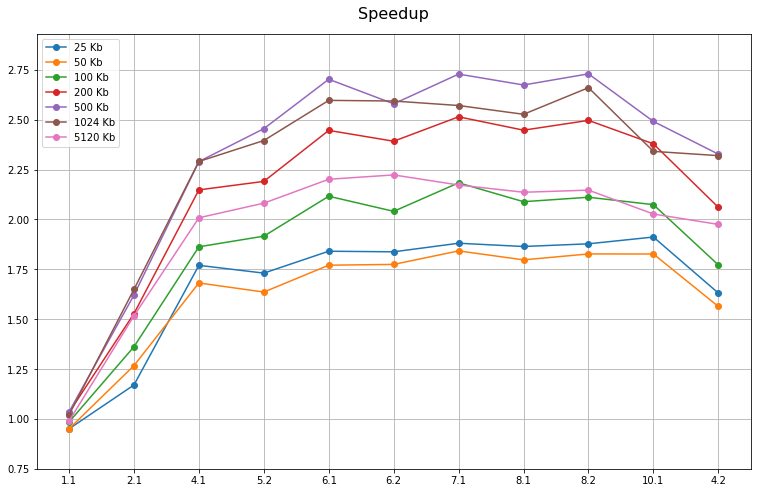

In [42]:
plot_line_chart("Speedup", speedup, chunk_sizes, thread_confs)

## Heat maps

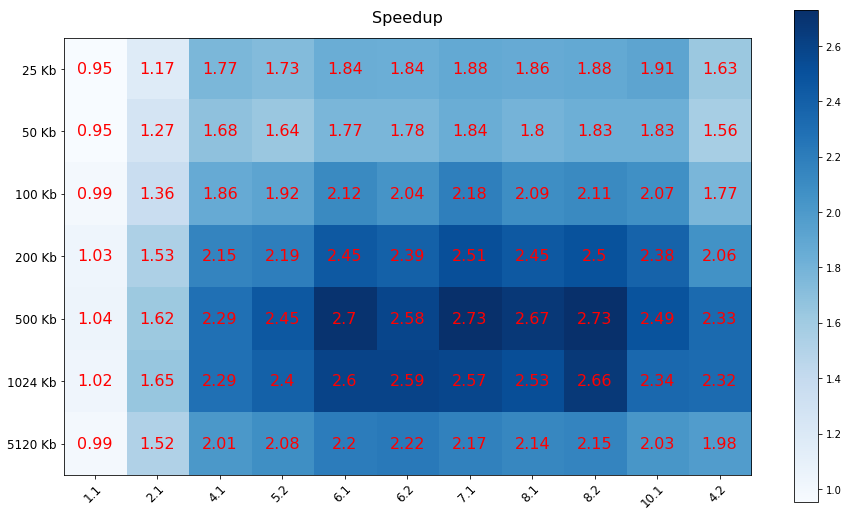

In [43]:
plot_heatmap('Speedup', speedup, get_vis_cnk_sizes(chunk_sizes), thread_confs, 'Blues', 'red')

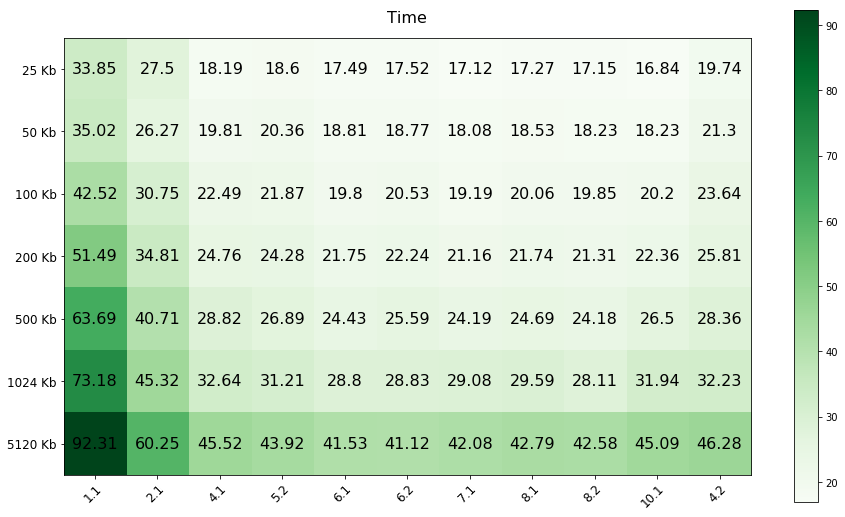

In [44]:
plot_heatmap('Time', parallel_compression_times, get_vis_cnk_sizes(chunk_sizes), thread_confs, 'Greens', 'black')

## 3D bar histograms 

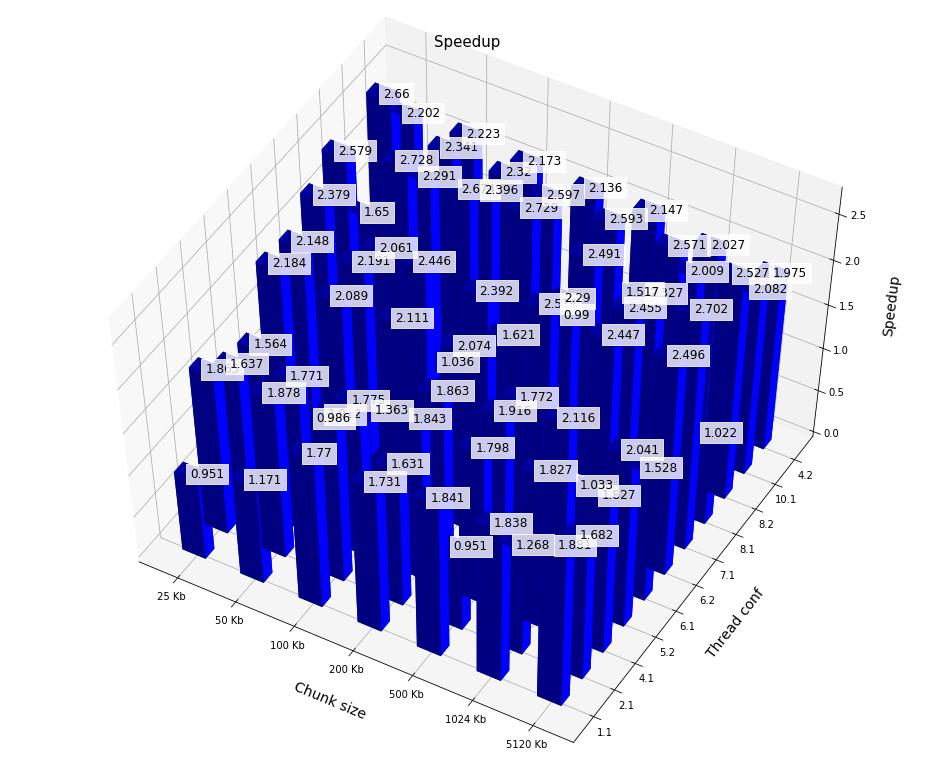

In [47]:
plot_3d_bar('Speedup', speedup, get_vis_cnk_sizes(chunk_sizes), thread_confs, 'b')

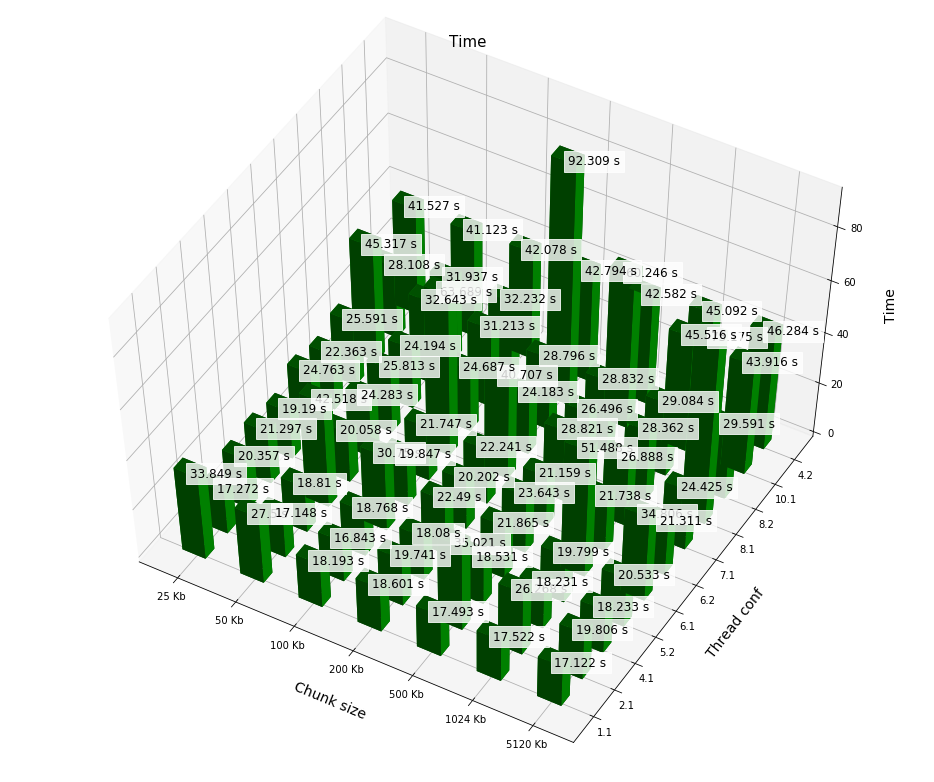

In [48]:
plot_3d_bar('Time', parallel_compression_times, get_vis_cnk_sizes(chunk_sizes), thread_confs, 'g')